In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
train_df = pd.read_csv("train_final.csv")
test_df  = pd.read_csv("test_final.csv")


target_col = "price_in_euro"


X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]


print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


X_train: (79460, 61) y_train: (79460,)
X_test : (19866, 61) y_test : (19866,)


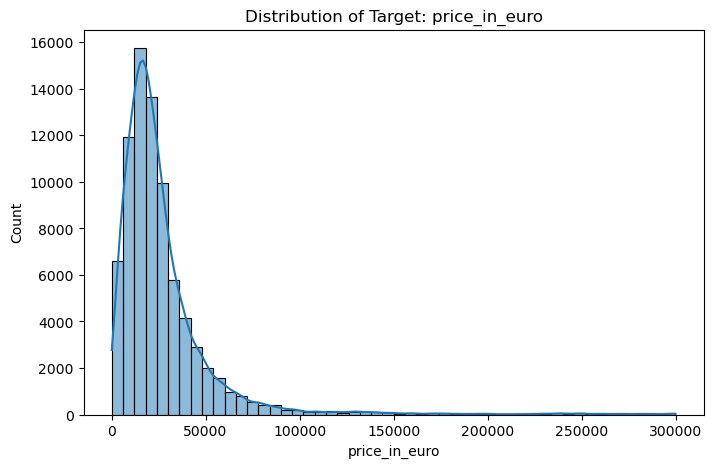

In [17]:


plt.figure(figsize=(8,5))
sns.histplot(y_train, bins=50, kde=True)
plt.title("Distribution of Target: price_in_euro")
plt.show()


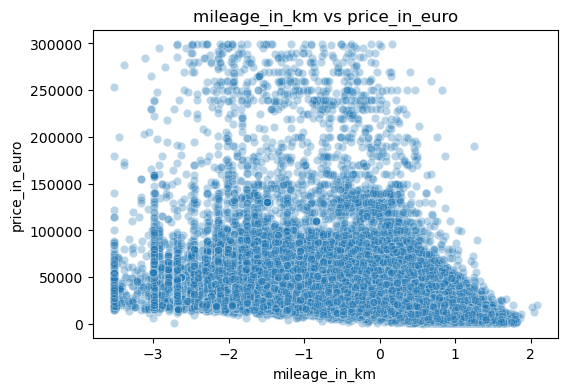

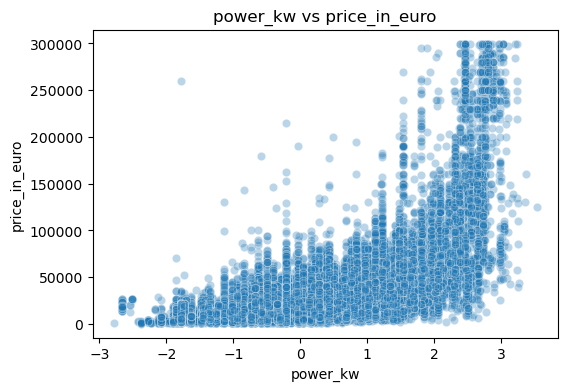

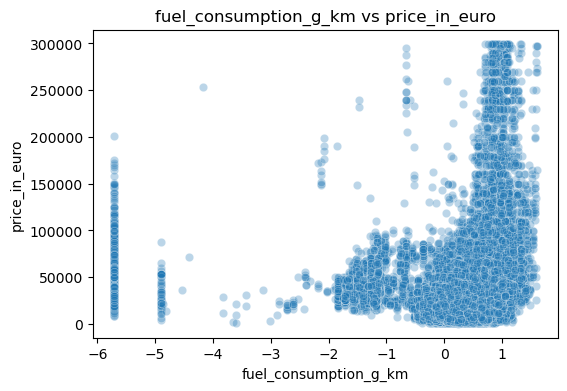

In [18]:
key_features = ["mileage_in_km", "power_kw", "fuel_consumption_g_km"]

for col in key_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_train[col], y=y_train, alpha=0.3)
    plt.title(f"{col} vs price_in_euro")
    plt.show()


In [19]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Results:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    
    return {"model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2}

In [20]:
dt = DecisionTreeRegressor(max_depth=20, min_samples_split=10, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
results_dt = evaluate_model(y_test, y_pred_dt, "Decision Tree")

Decision Tree Results:
MAE  : 4351.59
RMSE : 9124.76
R²   : 0.8970


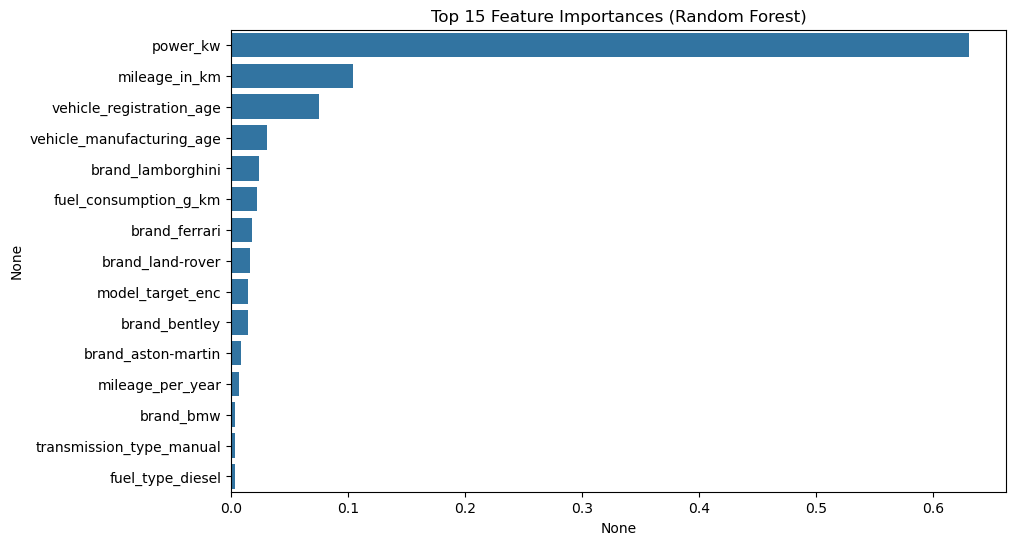

In [21]:
importances = dt.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance[:15], y=feat_importance.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [22]:
xgb = XGBRegressor(
    n_estimators=300, 
    learning_rate=0.1, 
    max_depth=8, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
results_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")


XGBoost Results:
MAE  : 3615.72
RMSE : 7321.92
R²   : 0.9337


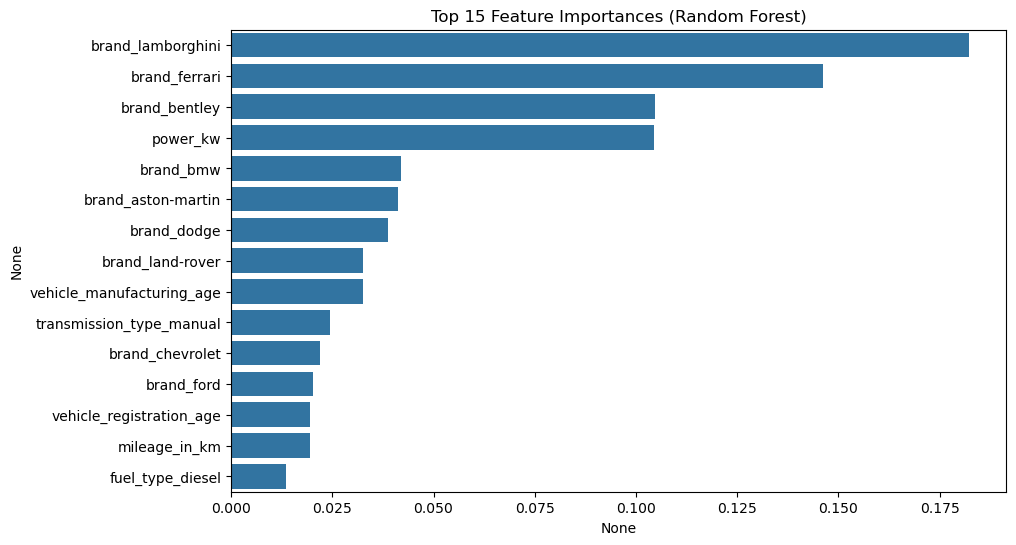

In [23]:
importances = xgb.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance[:15], y=feat_importance.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [24]:
rf = RandomForestRegressor(
    n_estimators=200, 
    max_depth=30, 
    min_samples_split=10,
    random_state=42, 
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
results_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")


Random Forest Results:
MAE  : 3527.89
RMSE : 7339.70
R²   : 0.9334


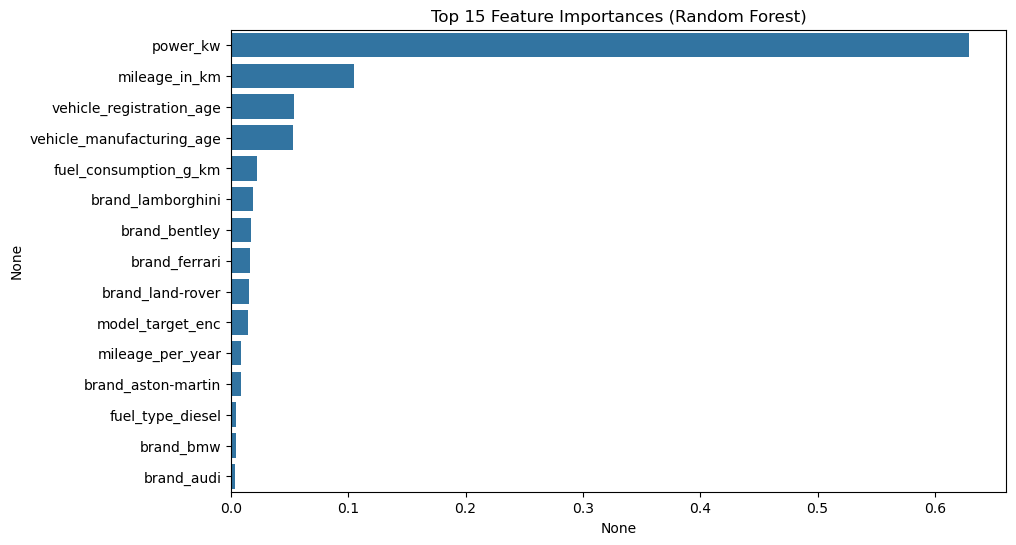

In [25]:
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance[:15], y=feat_importance.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [26]:
# Base model
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Parameter grid (broad search space)
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "reg_alpha": [0, 0.01, 0.1, 1],   # L1 regularization
    "reg_lambda": [1, 1.5, 2, 3]      # L2 regularization
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,             # try 30 random combinations
    scoring="neg_mean_absolute_error",  # optimize MAE
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score (MAE):", -random_search.best_score_)

# Evaluate on test set
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

results_xgb_tuned = evaluate_model(y_test, y_pred, "XGBoost Tuned")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 800, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV Score (MAE): 3731.856539301424
XGBoost Tuned Results:
MAE  : 3619.21
RMSE : 7330.11
R²   : 0.9336


In [27]:
import joblib
joblib.dump(best_xgb , "artifacts/model.joblib")

['artifacts/model.joblib']